In [1]:
# Computations
import numpy as np
import pandas as pd

# preprocessing
from sklearn import preprocessing

# sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# Progress Bar
import progressbar

# Visualisation libraries
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

<img src='https://upload.wikimedia.org/wikipedia/commons/5/51/IBM_logo.svg' width='350' align="center"/>

<div class="alert alert-block alert-info">
<font size="+2"><b>IBM HR Analytics Employee Attrition and Performance Dataset</b></font>
</div>

In this study, we analyze HR data available from   [kaggle.com](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) 

This data is **fictional** and it is created by IBM data scientists.

Categorical Parameters:

|                           |       1       |    2    |     3     |      4      |    5   |
|:-------------------------:|:-------------:|:-------:|:---------:|:-----------:|:------:|
|         Education         | Below College | College |  Bachelor |    Master   | Doctor |
|  Environment Satisfaction |      Low      |  Medium |    High   |  Very High  |        |
|      Job Involvement      |      Low      |  Medium |    High   |  Very High  |        |
|      Job Satisfaction     |      Low      |  Medium |    High   |  Very High  |        |
|     Performance Rating    |      Low      |   Good  | Excellent | Outstanding |        |
| Relationship Satisfaction |      Low      |  Medium |    High   |  Very High  |        |
|      WorkLife Balance     |      Bad      |   Good  |   Better  |     Best    |        |

This can be encoded as follows,

In [2]:
Categorical_Dict = {'Education': {1:'Below College', 2:'College',3:'Bachelor', 4: 'Master', 5:'Doctor'},
                    'Environment Satisfaction': {1:'Low', 2:'Medium', 3:'High', 4:'Very High'},
                    'Job Involvement': {1:'Low', 2:'Medium', 3:'High', 4:'Very High'},
                    'Job Satisfaction': {1:'Low', 2:'Medium', 3:'High', 4:'Very High'},
                    'Performance Rating': {1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'},
                    'Relationship Satisfaction': {1:'Low', 2:'Medium', 3:'High', 4:'Very High'},
                    'Work Life Balance': {1:'Bad', 2:'Good', 3:'Better', 4:'Best'}}

#### Loading the Dataset

In [3]:
Data = pd.read_excel('Data/WA_Fn-UseC_-HR-Employee-Attrition.xlsx')
Data.head().style.hide_index()

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


A number of functions and definitions that we use throughout this article.

In [4]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdYlGn", n_colors=Correlation_Matrix.shape[1]),
                linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()

def Search_List(Inp, MyList):
    ''' Search for specific value (Inp) in the column list '''
    Out=list()
    for i in MyList:
        if i.find(Inp) != -1:
            Out.append(i)
    return Out

def ROC_Curve(clf, X_test, delta = 0.05, Title = None):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([-delta,1+delta])
    _ = ax.set_ylim([-delta,1+delta])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title(Title)
    
Labels = ['Remanined', 'Churned']

# Problem Description

In the dataset, **Attrition** represents whether an employee is churned or not. We would like to create a predictive model that predicts this feature.

# Modeling

We need to convert categorical data to numeric data.

In [5]:
def dtypes_group(Inp):
    Temp = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = pd.DataFrame(index =Temp['Data Type'].unique(), columns = ['Columns'])
    for c in Temp['Data Type'].unique():
        Out.loc[Out.index == c, 'Columns'] = [Temp.loc[Temp['Data Type'] == c].index.tolist()]
    return Out
dtypes = dtypes_group(Data)
display(dtypes)

,Columns
int64,"[Age, YearsInCurrentRole, YearsAtCompany, Work..."
object,"[Over18, JobRole, EducationField, Gender, Depa..."


We can use **[LabelEncoder](#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)** for converting categorical to numeric using. Therefore,

In [6]:
df = Data.copy()
Columns = dtypes.loc[dtypes.index == 'object'].values[0,0]
N = len(Columns)
# Progressbar
Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval= N, widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])

#--------------- the loop ----------------------
Progress_Bar.start()
for i in range(N):
    le = preprocessing.LabelEncoder()
    le.fit(list(df[Columns[i]]))
    df[Columns[i]] = le.transform(df[Columns[i]])
    del le
    Progress_Bar.update(Counter)
    Counter+=1
Progress_Bar.finish()
#--------------- End of the loop ---------------

# Finally, converting values of df back to integers.
df = df.astype(int)

display(dtypes_group(df))

|=========================================================================|100%


,Columns
int32,"[Age, MonthlyRate, NumCompaniesWorked, Over18,..."


## Correlation

Furthemore, let's look at the variance of our dataset features.

In [7]:
Target = 'Attrition'
display(df.drop(columns = [Target, 'EmployeeNumber']).var().sort_values(ascending = False).to_frame(name= 'Variance')\
        .style.background_gradient(cmap='OrRd').set_precision(2))

,Variance
MonthlyRate,50662878.17
MonthlyIncome,22164857.07
DailyRate,162819.59
HourlyRate,413.29
Age,83.46
DistanceFromHome,65.72
TotalWorkingYears,60.54
YearsAtCompany,37.53
PercentSalaryHike,13.40
YearsInCurrentRole,13.13


Furthermore, we would like to standardize features by removing the mean and scaling to unit **variance**. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification.html), we demonstrated the benefits of scaling data using [**StandardScaler()**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [8]:
Temp = df.columns.tolist()
Temp = list(set(Temp) - set([Target,'EmployeeNumber']))

scaler = preprocessing.StandardScaler()
df[Temp] = scaler.fit_transform(df[Temp])
Temp = df[Temp].var().sort_values(ascending = False).to_frame(name= 'Variance')    
display(Temp.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)).set_precision(2))

,Variance
OverTime,1.00
YearsInCurrentRole,1.00
Gender,1.00
YearsWithCurrManager,1.00
Education,1.00
RelationshipSatisfaction,1.00
EducationField,1.00
Age,1.00
TotalWorkingYears,1.00
JobRole,1.00


Therefore, we can drop columns that have variance zero.

In [9]:
display(Temp[Temp.Variance == 0].index.tolist())
df.drop(columns = Temp[Temp.Variance == 0].index.tolist(), inplace = True)

['Over18', 'EmployeeCount', 'StandardHours']

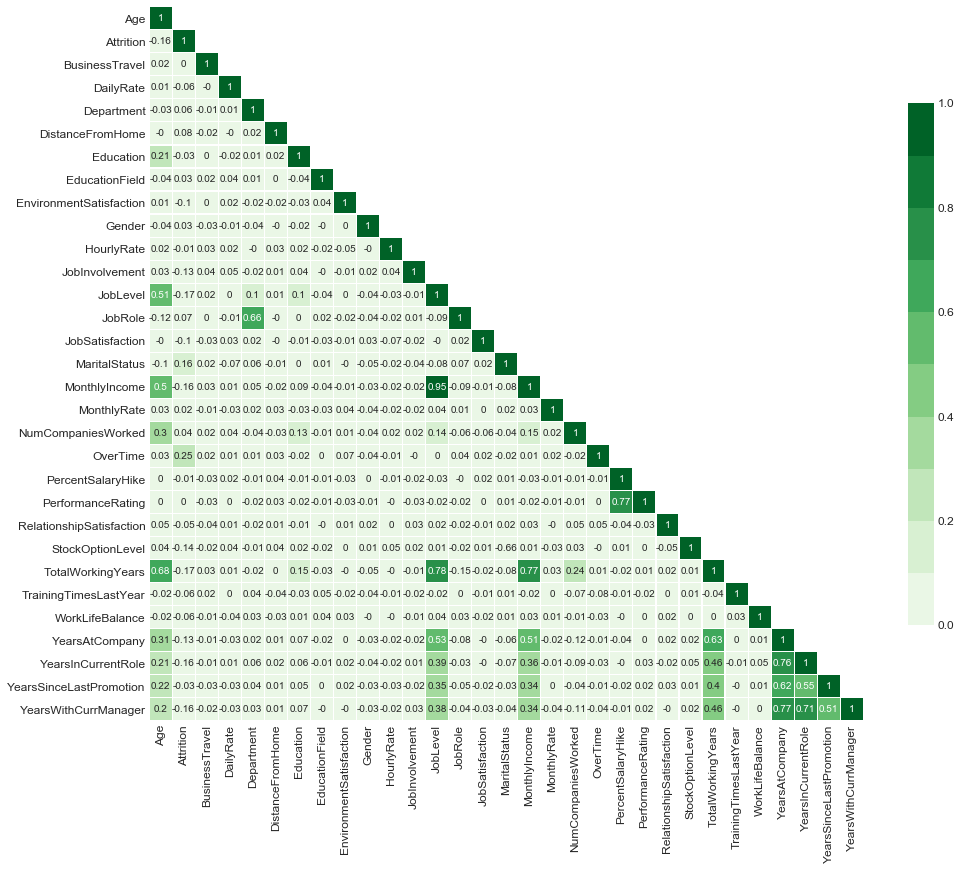

In [10]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("Greens", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .6})

Correlation_Plot (df.drop(columns = ['EmployeeNumber']), 16)

## Training and testing sets

We also don't need **EmployeeNumber** for this part of our study. Hence,

In [11]:
Temp = df.drop(columns = ['EmployeeNumber'])
X = Temp.drop(columns = Target)
y = Temp[Target]
del Temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(1029, 30)","(441, 30)","(1029,)","(441,)"


## Classifiers

For the next part, we use ROC (receiver operating characteristic curve) AUC (Area Under the ROC Curve) mean and standard deviations for demonstrating a classification model (See more [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)).

In [12]:
classifiers = {'Decision Tree Regression': DecisionTreeRegressor(),
               'Logistic Regression': LogisticRegression(solver='liblinear', random_state=10, class_weight='balanced'),
               'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=10),
               'Decision Tree Classifier': DecisionTreeClassifier(random_state=10),
               'Gaussian NB': GaussianNB()}

# Creating a Table
Results = pd.DataFrame(columns = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD'])
Mtds = list(classifiers.keys())
kfold = KFold(n_splits=20, random_state=10)

# Start ------------------------------------------------------------------
Progress_Bar = progressbar.ProgressBar(maxval=len(Mtds),
                                       widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])
Progress_Bar.start()

for i in range(len(Mtds)):
    model_name = Mtds[i]
    model = classifiers[model_name]
    Temp = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    Temp1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    Results.loc[i] = [model_name, round(Temp1.mean()*100, 2), round(Temp1.std()*100, 2),
                         round(Temp.mean()*100, 2), round(Temp.std()*100, 2)]
    Progress_Bar.update(i)
Progress_Bar.finish()
# End ------------------------------------------------------------------
del i, model, model_name, Temp, Temp1
Results = Results.sort_values(by=['ROC AUC Mean'], ascending=False)
display(Results.style.hide_index().background_gradient(cmap='Greens', subset=['ROC AUC Mean'] ).set_precision(2))

|=========================================================================|100%


Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
Logistic Regression,81.34,7.13,75.40,5.22
Random Forest Classifier,80.67,8.31,85.31,5.29
Gaussian NB,77.55,9.33,75.97,6.94
Decision Tree Regression,60.81,9.72,74.25,6.09
Decision Tree Classifier,60.57,7.44,75.90,4.71


## Stacking Classifier

Here, we create a stack of estimators to improve the accuracy of our predictions.

In [13]:
Temp = Results.loc[Results['ROC AUC Mean'] >= 70, 'Algorithm'].tolist()
Top = [(i, classifiers[i]) for i in Temp]
stacked = StackingClassifier(estimators = Top, final_estimator= classifiers[Temp[0]])
_ = stacked.fit(X_train, y_train)

Temp = cross_val_score(stacked, X_train, y_train, cv=kfold, scoring='accuracy')
Temp1 = cross_val_score(stacked, X_train, y_train, cv=kfold, scoring='roc_auc')
Results.loc[-1] = ['Stacked', round(Temp1.mean()*100, 2), round(Temp1.std()*100, 2), round(Temp.mean()*100, 2),
                   round(Temp.std()*100, 2)]
del Temp, Temp1
Results = Results.sort_values(by=['ROC AUC Mean'], ascending=False)
display(Results.style.hide_index().background_gradient(cmap='Greens', subset=['ROC AUC Mean'] ).set_precision(2))

Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
Stacked,82.30,7.77,76.47,3.44
Logistic Regression,81.34,7.13,75.40,5.22
Random Forest Classifier,80.67,8.31,85.31,5.29
Gaussian NB,77.55,9.33,75.97,6.94
Decision Tree Regression,60.81,9.72,74.25,6.09
Decision Tree Classifier,60.57,7.44,75.90,4.71


## ROC Curve

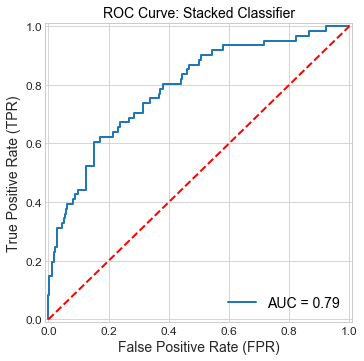

In [14]:
ROC_Curve(stacked, X_test, delta = 0.01, Title = 'ROC Curve: Stacked Classifier')

## Confusion Matrix

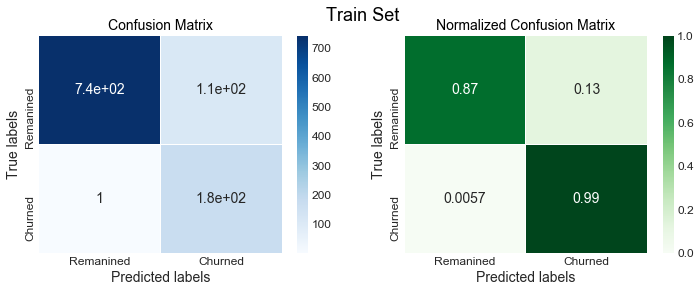

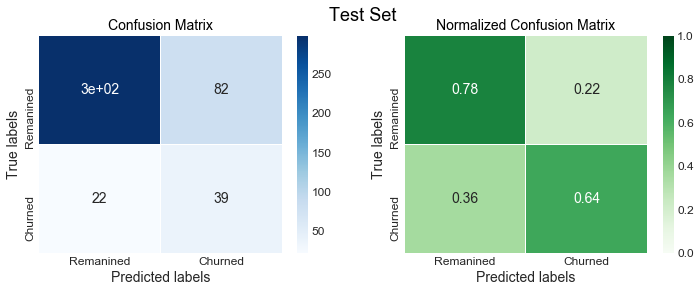

In [15]:
# Train set
y_pred = stacked.predict(X_train)
Confusion_Matrix = metrics.confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = stacked.predict(X_test)
Confusion_Matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

## Predictions

In [16]:
Test = X_test[:10]
Ind = Test .index
Pred = Data.loc[Data.index.isin(Ind),['EmployeeNumber', 'Attrition']]
Pred.columns = ['Employee Number', 'Attrition (Exact)']
Pred['Attrition (Predicted)'] = stacked.predict(Test)
Pred['Attrition (Predicted)'] = Pred['Attrition (Predicted)'].map({0:'No', 1:'Yes'})
Pred.style.hide_index()

Employee Number,Attrition (Exact),Attrition (Predicted)
63,No,No
86,No,No
250,No,Yes
302,No,No
304,No,No
332,No,Yes
577,No,Yes
666,No,No
1469,No,No
1714,Yes,No


***